### Plot Gravitino results using the DataFrame stored in GravitinoResults.pcl 

In [1]:
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from commonRCparameters import params
from collections import OrderedDict


pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update(params)  #Set general plotting options
import seaborn as sns
sns.set() #Set style
sns.set_style('ticks')
sns.set_context('paper', font_scale=1.5, rc={'figure.figsize' : (15,10)})

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('GravitinoResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

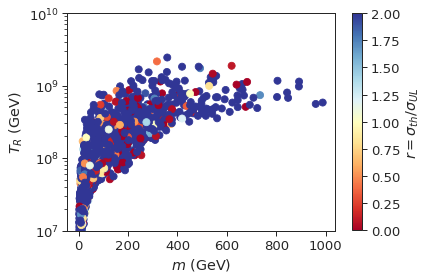

In [3]:
mG = dataDF['mG']
TR = dataDF['TR']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mG,TR,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e7,1e10)
# plt.xlim(80,300)
plt.savefig('IDM_points_r.png')
plt.show()

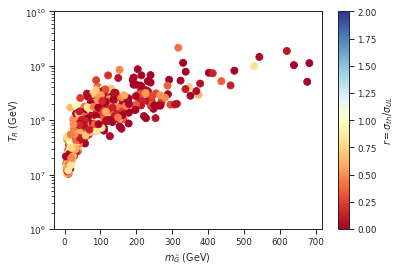

In [17]:
allowedDF = dataDF[dataDF['ExptRes.result0.r'] < 1.]
mG = allowedDF['mG']
TR = allowedDF['TR']
r = allowedDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mG,TR,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e6,1e10)
plt.show()

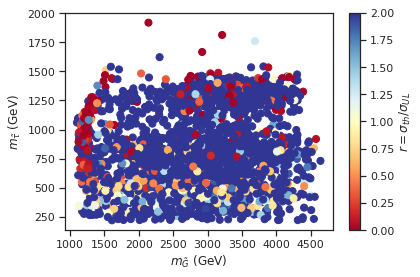

In [10]:
mgluino = dataDF['mass.1000021']
mstau = dataDF['mass.1000015']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mgluino,mstau,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cb = plt.colorbar(cp)
# plt.yscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$m_{\tilde{\tau}}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.show()

In [11]:
def getShortTxname(txList):
    if not isinstance(txList,list):
        return 'None'
    if len(txList) < 1:
        return 'None'
    elif len(txList) == 1:        
        return txList[0]
    else:
        if 'HSCP' in txList[0]:        
            return 'MultiHSCP'
        else:
            return 'MultiMET'
#Add short Txname notation:
dataDF['txshort'] = dataDF['ExptRes.result0.TxNames'].map(getShortTxname)

In [12]:
#Define topology dictionary
txDict = {'MultiHSCP' : 'Multiple HSCP Topologies', 
          'THSCPM1b' : r'$p p \to X_{HSCP} + X_{HSCP}$',
         'THSCPM3' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM$',
         'THSCPM5' : r'$p p \to Z + Z,\; Z \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM8' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM + SM$',
         'TRHadGM1' : r'$p p \to G_{R-hadron} + G_{R-hadron}$',
         'TRHadQM1' : r'$p p \to Q_{R-hadron} + Q_{R-hadron}$',
          'Allowed' : 'Not Excluded'
         }

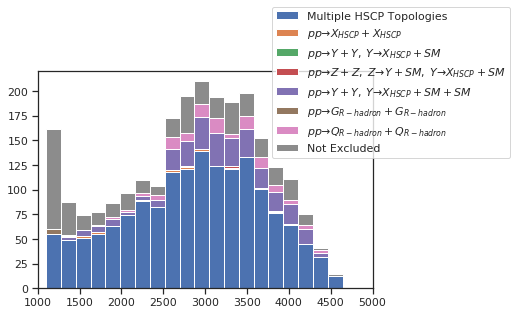

In [13]:
groupedDF = OrderedDict([[tx,dataDF[(dataDF['txshort'] == tx) & (dataDF['ExptRes.result0.r'] > 1.)]] for tx in txDict])
groupedDF.update({'Allowed' : dataDF[dataDF['ExptRes.result0.r'] <= 1.]})
xvals = [gDF['mass.1000021'] for gDF in groupedDF.values()]
nbins = 20
n, bins, patches = plt.hist(xvals,nbins,stacked=True, histtype='bar',label=[txDict[k] for k in groupedDF])
plt.legend(loc=(0.7,0.6))
plt.xlim(1000.,5000.)
plt.show()